In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

In [ ]:
from typing import Dict, Text

import os
import tempfile
import numpy as np
import csv
import pandas as pd
import tensorflow as tf
import time
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [ ]:
# read data from csv files
reviews_df = pd.read_csv('100_real_data.csv')

In [ ]:
reviews_df['brand'] = reviews_df['brand'].astype(str)
reviews_df['category2'] = reviews_df['category2'].astype(str)
reviews_df['category3'] = reviews_df['category3'].astype(str)
reviews_df['title'] = reviews_df['title'].astype(str)
reviews_df['description'] = reviews_df['description'].astype(str)
reviews_df['feature'] = reviews_df['feature'].astype(str)

In [ ]:
# convert dataframe to tensor dataset format
reviews = tf.data.Dataset.from_tensor_slices(dict(reviews_df))

In [ ]:
# confirm conversion successful
for row in reviews.take(3):
  print(row)

{'description': <tf.Tensor: shape=(), dtype=string, numpy=b'Pushing the boundaries of what fans have come to expect from the record-setting entertainment franchise'>, 'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Call of Duty: Black Ops II - Xbox 360'>, 'brand': <tf.Tensor: shape=(), dtype=string, numpy=b'by\n    \n    Activision'>, 'feature': <tf.Tensor: shape=(), dtype=string, numpy=b'Strike Force Levels: New to the Call of Duty Franchise'>, 'date': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'price': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'productID': <tf.Tensor: shape=(), dtype=string, numpy=b'B007XVTR3K'>, 'category2': <tf.Tensor: shape=(), dtype=string, numpy=b' Xbox 360'>, 'category3': <tf.Tensor: shape=(), dtype=string, numpy=b' Games'>, 'userID': <tf.Tensor: shape=(), dtype=string, numpy=b'A3QTRFAU7T5X9Y'>, 'vote': <tf.Tensor: shape=(), dtype=int64, numpy=449>, 'rating': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'verified': <tf.Tensor: shape=(), dtype=int64, n

In [ ]:
# select the features to map
reviews = reviews.map(lambda x: {
    "productID": x["productID"],      # embedding
    "userID": x["userID"],            # embedding
    "rating": x["rating"],            # target
    "vote": x["vote"],                # numeric
    # "title": x["title"],              # text
    # "brand": x["brand"],              # text
    "date": x["date"],                # numeric
    "price": x["price"],              # numeric
    # "description": x["description"],  # text
    # "feature": x["feature"],          # text
    # "category2": x["category2"],      # text
    # "category3": x["category3"],      # text
    "verified": x["verified"]         # numeric
    })

products = reviews.map(lambda x: {
    "productID": x["productID"]})

In [ ]:
# titles = reviews.map(lambda x: {
#     "title": x["title"]})

# titles  = reviews.map(lambda x: str(x['title']))
# brands = interactions.map(lambda x: str(x['brand']))
# category = interactions.map(lambda x: str(x['product_category']))

In [ ]:
start1 = time.time()
votes = np.concatenate(list(reviews.map(lambda x: x["vote"]).batch(100)))
mx_v, mn_v = votes.max(), votes.min()
vote_buckets = np.linspace(mn_v, mx_v, num=1000)

prices = np.concatenate(list(reviews.map(lambda x: x["price"]).batch(100)))
mx_p, mn_p = prices.max(), prices.min()
price_buckets = np.linspace(mn_p, mx_p, num=1000)

verified = np.concatenate(list(reviews.map(lambda x: x["verified"]).batch(100)))
mx_v, mn_v = verified.max(), verified.min()
verified_buckets = np.linspace(mn_v, mx_v, num=1000)

dates = np.concatenate(list(reviews.map(lambda x: x["date"]).batch(100)))
mx_d, mn_d = dates.max(), dates.min()
date_buckets = np.linspace(mn_d, mx_d, num=1000)

u_pids = np.unique(np.concatenate(list(products.batch(1000).map(lambda x: x["productID"]))))
u_uids = np.unique(np.concatenate(list(reviews.batch(1000).map(lambda x: x["userID"]))))

# u_titles = np.unique(np.concatenate(list(reviews.batch(1000).map(lambda x: x["title"]))))
# u_brands = np.unique(np.concatenate(list(reviews.batch(1000).map(lambda x: x["brand"]))))
# u_descriptions = np.unique(np.concatenate(list(reviews.batch(1000).map(lambda x: x["description"]))))
# u_features = np.unique(np.concatenate(list(reviews.batch(1_000).map(lambda x: x["feature"]))))
# u_category2 = np.unique(np.concatenate(list(reviews.batch(1_000).map(lambda x: x["category2"]))))
# u_category3 = np.unique(np.concatenate(list(reviews.batch(1_000).map(lambda x: x["category3"]))))

In [ ]:
# define a user model
class UserModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10_000
    self.embedding_dimension = 32

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(vocabulary=u_uids, mask_token=None),
        tf.keras.layers.Embedding(len(u_uids) + 1, 64)])

    self.vote_embedding = tf.keras.Sequential([
        tf.keras.layers.Discretization(vote_buckets.tolist()),
        tf.keras.layers.Embedding(len(vote_buckets) + 2, 32)])
    self.normalized_vote = tf.keras.layers.Normalization(axis=None)
    self.normalized_vote.adapt(votes)

    self.verified_embedding = tf.keras.Sequential([
        tf.keras.layers.Discretization(verified_buckets.tolist()),
        tf.keras.layers.Embedding(len(verified_buckets) + 2, 32)])
    self.normalized_verified = tf.keras.layers.Normalization(axis=None)
    self.normalized_verified.adapt(verified)

    self.date_embedding = tf.keras.Sequential([
        tf.keras.layers.Discretization(date_buckets.tolist()),
        tf.keras.layers.Embedding(len(date_buckets) + 2, 32)])
    self.normalized_date = tf.keras.layers.Normalization(axis=None)
    self.normalized_date.adapt(votes)

    self.price_embedding = tf.keras.Sequential([
        tf.keras.layers.Discretization(price_buckets.tolist()),
        tf.keras.layers.Embedding(len(price_buckets) + 2, 32)])
    self.normalized_price = tf.keras.layers.Normalization(axis=None)
    self.normalized_price.adapt(prices)

    # self.title_embedding = tf.keras.Sequential([
    #           tf.keras.layers.experimental.preprocessing.StringLookup(
    #             vocabulary=u_titles, mask_token=None),
    #           tf.keras.layers.Embedding(len(u_titles) + 1, 
    #                                     self.embedding_dimension)
    #         ])
    

    # self.title_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    #                                                                                 max_tokens=max_tokens)
    # self.title_text_embedding = tf.keras.Sequential([
    #                           self.title_vectorizer,
    #                           tf.keras.layers.Embedding(max_tokens, 
    #                                                     self.embedding_dimension, 
    #                                                     mask_zero=True),
    #                           tf.keras.layers.GlobalAveragePooling1D(),
    #                         ])
    # self.title_vectorizer.adapt(titles)

    

    # self.brand_embedding = tf.keras.Sequential([
    #           tf.keras.layers.experimental.preprocessing.StringLookup(
    #             vocabulary=u_brands, mask_token=None),
    #           tf.keras.layers.Embedding(len(u_brands) + 1, 
    #                                     self.embedding_dimension)
    #         ])
    
    # self.brand_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    #                                                                                 max_tokens=max_tokens)
    # self.brand_text_embedding = tf.keras.Sequential([
    #                           self.brand_vectorizer,
    #                           tf.keras.layers.Embedding(max_tokens, 
    #                                                     self.embedding_dimension, 
    #                                                     mask_zero=True),
    #                           tf.keras.layers.GlobalAveragePooling1D(),
    #                         ])
    

    # self.description_embedding = tf.keras.Sequential([
    #           tf.keras.layers.experimental.preprocessing.StringLookup(
    #             vocabulary=u_descriptions, mask_token=None),
    #           tf.keras.layers.Embedding(len(u_descriptions) + 1, 
    #                                     self.embedding_dimension)
    #         ])
    
    # self.description_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    #                                                                                 max_tokens=max_tokens)
    # self.description_text_embedding = tf.keras.Sequential([
    #                           self.description_vectorizer,
    #                           tf.keras.layers.Embedding(max_tokens, 
    #                                                     self.embedding_dimension, 
    #                                                     mask_zero=True),
    #                           tf.keras.layers.GlobalAveragePooling1D(),
    #                         ])
  

    # self.feature_embedding = tf.keras.Sequential([
    #           tf.keras.layers.experimental.preprocessing.StringLookup(
    #             vocabulary=u_features, mask_token=None),
    #           tf.keras.layers.Embedding(len(u_features) + 1, 
    #                                     self.embedding_dimension)
    #         ])
    
    # self.feature_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    #                                                                                 max_tokens=max_tokens)
    # self.feature_text_embedding = tf.keras.Sequential([
    #                           self.feature_vectorizer,
    #                           tf.keras.layers.Embedding(max_tokens, 
    #                                                     self.embedding_dimension, 
    #                                                     mask_zero=True),
    #                           tf.keras.layers.GlobalAveragePooling1D(),
    #                         ])
    

    # self.category2_embedding = tf.keras.Sequential([
    #           tf.keras.layers.experimental.preprocessing.StringLookup(
    #             vocabulary=u_category2, mask_token=None),
    #           tf.keras.layers.Embedding(len(u_category2) + 1, 
    #                                     self.embedding_dimension)
    #         ])
    
    # self.category2_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    #                                                                                 max_tokens=max_tokens)
    # self.category2_text_embedding = tf.keras.Sequential([
    #                           self.category2_vectorizer,
    #                           tf.keras.layers.Embedding(max_tokens, 
    #                                                     self.embedding_dimension, 
    #                                                     mask_zero=True),
    #                           tf.keras.layers.GlobalAveragePooling1D(),
    #                         ])
    

    # self.category3_embedding = tf.keras.Sequential([
    #           tf.keras.layers.experimental.preprocessing.StringLookup(
    #             vocabulary=u_category3, mask_token=None),
    #           tf.keras.layers.Embedding(len(u_category3) + 1, 
    #                                     self.embedding_dimension)
    #         ])
    
    # self.category3_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    #                                                                                 max_tokens=max_tokens)
    # self.category3_text_embedding = tf.keras.Sequential([
    #                           self.category3_vectorizer,
    #                           tf.keras.layers.Embedding(max_tokens, 
    #                                                     self.embedding_dimension, 
    #                                                     mask_zero=True),
    #                           tf.keras.layers.GlobalAveragePooling1D(),
    #                         ])
    




  def call(self, inputs):
    return tf.concat([
        self.user_embedding(inputs["userID"]),
        self.vote_embedding(inputs["vote"]),
        tf.reshape(self.normalized_vote(inputs["vote"]), (-1, 1)),
        self.verified_embedding(inputs["verified"]),
        tf.reshape(self.normalized_verified(inputs["verified"]), (-1, 1)),
        self.date_embedding(inputs["date"]),
        tf.reshape(self.normalized_verified(inputs["date"]), (-1, 1)),
        self.price_embedding(inputs["price"]),
        tf.reshape(self.normalized_vote(inputs["price"]), (-1, 1)),
        # self.title_embedding(inputs["title"]),
        # self.title_text_embedding(inputs["title"]),
        # self.brand_embedding(inputs["brand"]),
        # self.brand_text_embedding(inputs["brand"]),
        # self.description_embedding(inputs["description"]),
        # self.description_text_embedding(inputs["description"]),
        # self.feature_embedding(inputs["feature"]),
        # self.feature_text_embedding(inputs["feature"]),
        # self.category2_embedding(inputs["category2"]),
        # self.category2_text_embedding(inputs["category2"]),
        # self.category3_embedding(inputs["category3"]),
        # self.category3_text_embedding(inputs["category3"]),
    ], axis=1)

In [ ]:
class ProductModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    self.product_embedding = tf.keras.Sequential([
                  tf.keras.layers.experimental.preprocessing.StringLookup(
                      vocabulary=u_pids, mask_token=None),
                  tf.keras.layers.Embedding(len(u_pids) + 1, 64)])
    
  
  def call(self, inputs):
    print(inputs)
    return tf.concat([ 
        self.product_embedding(inputs["productID"])
    ], axis=1)

In [ ]:
# define a recommender model
class ProductRecommendationModel(tfrs.models.Model):

  def __init__(self, rating_weight, retrieval_weight):
    super().__init__()

    # user and product representations
    self.user_model = tf.keras.Sequential([
                      UserModel(),
                      tf.keras.layers.Dense(64)])
    
    ## candidate model is the item model
    self.product_model = tf.keras.Sequential([
                          ProductModel(),
                          tf.keras.layers.Dense(64)])

        
    # model using user and product embeddings to predict ratings
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # loss weights
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

    # retrieval tasks: factorization loss and RMSE
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=products.batch(128).map(self.product_model)
        )
    )



  def compute_loss(self, features, training=False):
    # define how the loss is computed
    ratings = features.pop("rating")

    user_embeddings = self.user_model({
        "userID": features["userID"],
        "vote": features["vote"],
        "verified": features["verified"],
        "date": features["date"],
        "price": features["price"], 
        # "title": features["title"], 
        # "description": features["description"], 
        # "brand": features["brand"], 
        # "feature": features["feature"], 
        # "category2": features["category2"],  
        # "category3": features["category3"]
    })
    print(features)

    product_embeddings = self.product_model({
        "productID": features["productID"],  
    })
    
    rating_predictions = self.rating_model(
        tf.concat([user_embeddings, product_embeddings], axis=1)
    )  

    # compute loss for each task
    rating_loss = self.rating_task(labels=ratings, predictions=rating_predictions)
    retrieval_loss = self.retrieval_task(user_embeddings, product_embeddings)

    # combine them using the loss weights
    return (self.rating_weight * rating_loss + self.retrieval_weight * retrieval_loss)


In [ ]:
# create retrieval and ranking model
model = ProductRecommendationModel(rating_weight=0.5, retrieval_weight=0.5)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

# split the data into a training set and a testing set.
tf.random.set_seed(42)
shuffled = reviews.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

# train model
start = time.time()
history = model.fit(cached_train, epochs=10)
end = time.time()
print("TIME TO TRAIN MODEL:", str(datetime.timedelta(seconds=end-start)))

# print result metrics
start = time.time()
model.evaluate(cached_test, return_dict=True)
end = time.time()
print("TIME TO EVALUATE MODEL:", str(datetime.timedelta(seconds=end-start)))
end1 = time.time()
print("\n\n\n ----------------------------------------------------- \n\nTOTAL TIME TO TRAIN MODEL:", str(datetime.timedelta(seconds=end1-start1)))

Consider rewriting this model with the Functional API.
{'productID': <tf.Tensor 'args_0:0' shape=(None,) dtype=string>}
Epoch 1/10
Consider rewriting this model with the Functional API.
{'productID': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>, 'userID': <tf.Tensor 'IteratorGetNext:4' shape=(None,) dtype=string>, 'vote': <tf.Tensor 'IteratorGetNext:6' shape=(None,) dtype=int64>, 'date': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=int64>, 'price': <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>, 'verified': <tf.Tensor 'IteratorGetNext:5' shape=(None,) dtype=int64>}
Consider rewriting this model with the Functional API.
{'productID': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>}
Consider rewriting this model with the Functional API.
{'productID': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>, 'userID': <tf.Tensor 'IteratorGetNext:4' shape=(None,) dtype=string>, 'vote': <tf.Tensor 'IteratorGetNext:6' shape=(None,) dtype=int64>, 'd

In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

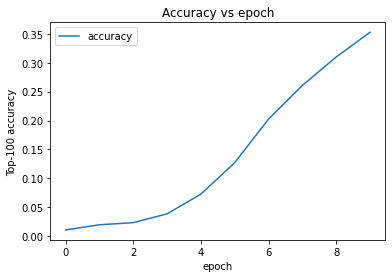

In [ ]:
# plot train accuracy over epochs
epochs = [i for i in range(10)]
plt.plot(epochs, history.history["factorized_top_k/top_10_categorical_accuracy"], label="accuracy")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()